In [1]:
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy as sc
import gc
import joblib

pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)

In [2]:
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

In [3]:
# Read csv
#file1 = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates_wWeek0.csv'
file2 = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates_wWeek0_date.csv'
df_data = pd.read_csv(file2, sep='|', dtype={'userID':np.uint32,
                                            #'purchaseDates':str,
                                            'date':str, 
                                            'itemID':np.uint32,
                                            'order':np.uint8,
                                            'brand':np.uint16,
                                            'feature_1':np.uint8,
                                            'feature_2':np.uint8,
                                            'feature_3':np.uint16,
                                            'feature_4':np.uint8,
                                            'feature_5':np.uint16,
                                            'week':np.uint8})
                     #chunksize=10000)

#df_data2 = pd.read_csv(r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates.csv', sep='|', chunksize=50000)

show_mem_usage(df_data)
df_data.head()
#df_data.get_chunk()

Memory usage of dataframe is 35.70 MB


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
1,2020-06-01,10318,4735,1,791,10,1,504,0,17,"[2459, 2197, 61, 3604, 1861, 3916]",0
2,2020-06-01,10318,20343,1,194,10,0,506,3,65535,"[826, 3755, 2041, 1546, 199, 2995, 871, 3702, ...",0
3,2020-06-01,10318,20672,1,963,10,0,507,3,123,"[806, 2091, 2073, 2304, 3976]",0
4,2020-06-01,10318,2918,1,441,10,0,507,0,39,"[2091, 2023]",0


# Preprocessing

In [4]:
# Drop columns (only for file1)
#df_data.drop('lastPurchaseDate', axis=1, inplace=True)
#df_data.drop('Unique count(date)', axis=1, inplace=True)

df_data = df_data.sort_values('date')

df_data.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,"[2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...",0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,"[30, 1763, 3915, 1060, 1525, 3914, 3444, 871]",0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,"[196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]",1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,[981],0


### Multi-Hot-Encoding for categories

In [5]:
# If you run out of memory while encoding the whole dataframe at once you can 
# split the dataframe into chunks beforehand 

#df_data_chunk = df_data.iloc[:150000,:] # set chunk size for tests
df_data_chunk = df_data

df_data_chunk.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,"[2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...",0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,"[30, 1763, 3915, 1060, 1525, 3914, 3444, 871]",0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,"[196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]",1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,[981],0


In [6]:
# convert string to list of integers in 'categories'
df_data_chunk["categories"] = df_data_chunk["categories"].apply(lambda x: [int(i) for i in x[1:-1].split(',')])
df_data_chunk["categories"]

0                                [74, 4109, 3867, 803, 4053]
3394       [2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...
3393           [30, 1763, 3915, 1060, 1525, 3914, 3444, 871]
3392         [196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]
3391                                                   [981]
3390                                 [2790, 871, 2417, 2454]
3389                                            [1920, 2658]
3388       [3766, 2389, 3693, 1174, 3173, 3625, 2872, 391...
3387                                             [2833, 498]
3386                                            [2799, 3244]
3385                            [2624, 3259, 88, 3349, 3653]
3384                           [3259, 987, 1064, 2624, 3653]
3383                          [2209, 3176, 3283, 2257, 3915]
3382                                   [47, 279, 1319, 3915]
3381       [664, 669, 1760, 1763, 3924, 3915, 3912, 3914,...
3380       [1515, 2330, 1760, 3245, 2443, 3173, 3915, 391...
3395                    

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
c = df_data_chunk["categories"]
mlb = MultiLabelBinarizer(sparse_output=False) # Set to True if output binary array is desired in CSR sparse format

df_multi_hot = pd.DataFrame(mlb.fit_transform(c), columns=mlb.classes_, index=None, dtype=np.int8)
#df_multi_hot = pd.DataFrame(mlb.fit_transform(c))
show_mem_usage(df_multi_hot)
df_multi_hot

Memory usage of dataframe is 3420.66 MB


,0,1,2,3,4,5,6,7,12,13,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
sparse_df_mh = df_multi_hot.astype(pd.SparseDtype("float64",0))
print(sparse_df_mh.info())
sparse_df_mh

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069416 entries, 0 to 1069415
Columns: 3354 entries, 0 to 4299
dtypes: Sparse[float64, 0](3354)
memory usage: 77.1 MB
None


,0,1,2,3,4,5,6,7,12,13,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
del df_multi_hot
gc.collect()

0

In [10]:
# Combine df_data and sparse_df_mh
df_combined = df_data_chunk.join(sparse_df_mh, how='inner')
show_mem_usage(df_combined)
df_combined.head()

Memory usage of dataframe is 120.91 MB


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# pop and append 'week' at end of dataframe
col = df_combined.pop("week")
df_combined.insert(len(df_combined.columns), col.name, col)
df_combined.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4288,4289,4290,4292,4293,4294,4296,4298,4299,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
# Check if we have any missing values
df_combined[df_combined.isnull().any(axis=1)]

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4288,4289,4290,4292,4293,4294,4296,4298,4299,week


### Datatypes for XGBoost

XGBoost natively supports continuous data but not categorical data. In order to use categorical data with XGBoost, we have to use One-Hot-Encoding which converts a column of categorical values into muliple columns of binary values.

# Modeling

In [13]:
df_combined.drop('categories', axis=1, inplace=True)
show_mem_usage(df_combined)

Memory usage of dataframe is 112.75 MB


In [14]:
# get index of first occurance of january date for split
idx = df_combined.date.searchsorted('2021-01-01', side='left') # list needs to be sorted already for searchsorted
idx

904092

In [15]:
# check index
df_combined['date'][idx], df_combined['date'][idx - 1]

('2021-01-01', '2020-12-31')

In [16]:
# drop date
df_combined.drop('date', axis=1, inplace=True)

In [17]:
# Comma is being used to extract a specific column from a 2D array.
# X = data.iloc[:,:-1]
# X = all rows, all columns except the last one 

X = df_combined.iloc[:,0:-1]
X

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,38769,3477,1,186,6,0,196,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,11575,3997,1,194,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,27306,27936,1,618,4,0,323,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2961,7021,1,1324,10,0,421,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,16239,8526,1,322,6,0,536,0,46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3390,8542,25689,1,1180,1,1,522,3,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3389,8001,2826,1,1111,10,0,487,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3388,38018,31702,3,703,10,0,345,0,97,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3387,38018,20101,1,1090,10,1,502,0,185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3386,38018,29741,1,1496,10,0,287,3,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
y = df_combined.iloc[:,-1]
y.head()

0       0
3394    0
3393    0
3392    1
3391    0
Name: week, dtype: uint8

In [19]:
# Split training/test data
# train = jun-dec20 / test = jan21
X_train = X.iloc[:idx-1]
X_test = X.iloc[idx:]
y_train = y.iloc[:idx-1]
y_test = y.iloc[idx:]

In [20]:
show_mem_usage(X_train), show_mem_usage(X_test)
X_train

Memory usage of dataframe is 88.15 MB
Memory usage of dataframe is 15.43 MB


,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4287,4288,4289,4290,4292,4293,4294,4296,4298,4299
0,38769,3477,1,186,6,0,196,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,11575,3997,1,194,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,27306,27936,1,618,4,0,323,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2961,7021,1,1324,10,0,421,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,16239,8526,1,322,6,0,536,0,46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3390,8542,25689,1,1180,1,1,522,3,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3389,8001,2826,1,1111,10,0,487,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3388,38018,31702,3,703,10,0,345,0,97,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3387,38018,20101,1,1090,10,1,502,0,185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3386,38018,29741,1,1496,10,0,287,3,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
y_train

0         0
3394      0
3393      0
3392      1
3391      0
3390      0
3389      0
3388      1
3387      0
3386      0
3385      1
3384      1
3383      1
3382      1
3381      0
3380      1
3395      0
3396      0
3397      0
3398      0
3414      0
3413      0
3412      1
3411      0
3410      0
3409      0
3408      0
3379      0
3407      0
3405      0
3404      0
3403      1
3402      0
3401      0
3400      0
3399      0
3406      0
3378      1
3377      0
3376      0
3355      1
3354      0
3353      0
3352      1
3351      1
3350      0
3349      0
3356      1
3348      0
3346      0
3345      0
3344      0
3343      1
3342      0
3341      0
3340      0
3347      0
3415      1
3357      0
3359      0
3375      1
3374      1
3373      0
3372      0
3371      0
3370      0
3369      0
3358      1
3368      0
3366      1
3365      0
3364      0
3363      1
3362      1
3361      1
3360      0
3367      1
3416      0
3417      0
3418      0
3474      1
3473      1
3472      1
3471

In [21]:
# Split training and test data
# parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

#show_mem_usage(X_train), show_mem_usage(X_test)

### Train Model (or load)

In [22]:
# train (if not loading, see below)
#model1 = XGBClassifier()
#xgm = model1.fit(X_train, y_train)

# use this for loading model:
filepath = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\models\gbm_jun-dec-train_completeLabeled_wWeek0.sav'
xgm = joblib.load(filepath)

# predict
y_train_pred = xgm.predict(X_train)
y_test_pred = xgm.predict(X_test)

# get accuracies
xgm_train = accuracy_score(y_train, y_train_pred)
xgm_test = accuracy_score(y_test, y_test_pred)
print()
print(f'XGboost train/test accuracies '
     f'{xgm_train:.3f}/{xgm_test:.3f}')


XGboost train/test accuracies 0.730/0.736


<AxesSubplot:>

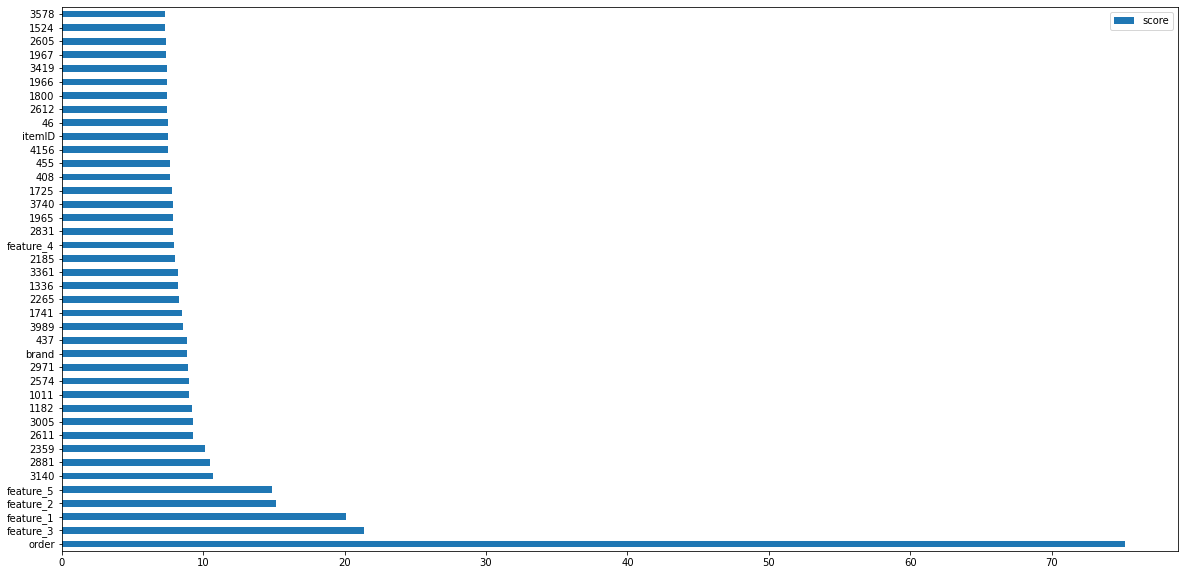

In [24]:
# ‘gain’: the average gain across all splits the feature is used in.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
feature_important = gbm.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

#### Save Model

In [27]:
# save model ('gbm', see above) with joblib

#filepath = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\models\gbm_jun-dec-train_completeLabeled_wWeek0.sav'
#joblib.dump(gbm, filepath)

### Predict

In [28]:
# create dataframe from test-prediction with index from X_test
df_y_test_pred = pd.DataFrame(y_test_pred, columns=['week_pred'], index=X_test.index, dtype=np.int8)

# concatenate X_test, y_test, y_pred (put columns next to each other)
df_eval_test = pd.concat([X_test, y_test, df_y_test_pred], axis=1)

In [29]:
# show rows of correctly predicted weeks where week != 0 
df_eval_test.loc[(df_eval_test['week'] == df_eval_test['week_pred']) & (df_eval_test['week'] != 0)].head(150)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4289,4290,4292,4293,4294,4296,4298,4299,week,week_pred
911289,5003,18796,4,186,4,0,28,3,175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
911360,45907,4091,5,347,4,0,324,0,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
918312,6374,32007,3,1496,10,0,43,0,156,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
918017,11102,5348,6,1145,4,0,39,0,151,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
919265,12,14005,2,400,4,0,322,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
920252,26200,4066,3,373,6,0,46,0,49,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
964834,2228,4349,2,1111,4,0,487,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
988452,1597,29657,6,18,10,0,345,0,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
1015098,10739,26010,3,504,10,0,441,3,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
1016315,25763,23050,4,1411,4,0,22,0,151,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4


In [30]:
# show 150 rows of predicted weeks where prediction was wrong
df_eval_test.loc[(df_eval_test['week'] != df_eval_test['week_pred']) & (df_eval_test['week'] != 0)].head(250)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4289,4290,4292,4293,4294,4296,4298,4299,week,week_pred
905945,45525,461,1,406,10,0,503,0,17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905930,36249,387,1,325,10,0,16,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905931,27130,23534,1,1180,4,0,398,0,129,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905932,27130,24303,1,797,10,0,491,0,156,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905946,9629,3113,1,290,10,0,345,3,99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905933,30838,6809,1,827,4,0,55,3,49,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905934,195,23348,1,1371,10,0,344,0,99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905935,10336,20478,1,539,6,0,303,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905938,28089,21704,1,186,4,0,15,0,81,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905937,45737,6112,1,1065,4,0,324,0,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


# DecisionTreeClassifier

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier

# train
classifier = DecisionTreeClassifier()
dcm = classifier.fit(X_train,y_train)

# use this for loading model:
#filepath = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\models\dcm_jun-dec-train_completeLabeled_wWeek0.sav'
#gbm = joblib.load(filepath)

# predict
y_train_pred2 = dcm.predict(X_train)
y_test_pred2 = dcm.predict(X_test)

# get accuracies
dcm_train = accuracy_score(y_train, y_train_pred2)
dcm_test = accuracy_score(y_test, y_test_pred2)
print()
print(f'DecTree train/test accuracies '
     f'{dcm_train:.3f}/{dcm_test:.3f}')

In [ ]:
# save model ('dcm', see above) with joblib

filepath = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\models\dcm_jun-dec-train_completeLabeled_wWeek0.sav'
joblib.dump(dcm, filepath)